In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [1]:
!nvidia-smi

Tue May 18 14:00:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/64x64.zip > /dev/null
# !unzip /content/drive/MyDrive/Colab\ Notebooks/32x32.zip > /dev/null

In [1]:
## libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys, os, time, csv, glob, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Convolution1D, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import metrics

## Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

# CNN 1.0 - Binary output (attack/normal)

In [2]:
train_normal = []
train_attack = []
test_normal = []
test_attack = []

for i in glob.glob('/content/64x64/train_normal/train_normal_*.jpg', recursive=True):
    train_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for j in glob.glob('/content/64x64/train_attack/train_attack_*.jpg', recursive=True):
    train_attack.append(cv2.imread(j, cv2.IMREAD_GRAYSCALE))

for k in glob.glob('/content/64x64/test_normal/test_normal_*.jpg', recursive=True):
    test_normal.append(cv2.imread(k, cv2.IMREAD_GRAYSCALE))

for l in glob.glob('/content/64x64/test_attack/test_attack_*.jpg', recursive=True):
    test_attack.append(cv2.imread(l, cv2.IMREAD_GRAYSCALE))

train_normal = np.array(train_normal)
train_attack = np.array(train_attack)
test_normal = np.array(test_normal)
test_attack = np.array(test_attack)

In [3]:
np.shape(train_normal), np.shape(train_attack), np.shape(test_normal), np.shape(test_attack)

# for i in range(0, 2):
#   plt.imshow(train_normal[i], cmap = 'gray')
#   plt.show()

# for i in train_normal:
#   print(i)

((1874, 64, 64), (1628, 64, 64), (271, 64, 64), (357, 64, 64))

In [4]:
## augmenting the data to create more images
## only run cell if needed

## vertically flip training images
vert_flip_train_attack = np.fliplr(train_attack)
vert_flip_train_normal = np.fliplr(train_normal)

## flip training images horizonatally
hor_flip_train_attack = np.rot90(train_attack, axes = (1,2), k = 2)
hor_flip_train_normal = np.rot90(train_normal, axes = (1,2), k = 2)

## rotate training images left and right once each
rotate90l_train_attack = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_attack = np.rot90(train_normal, -1, axes=(1, 2))
rotate90l_train_normal = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_normal = np.rot90(train_normal, -1, axes=(1, 2))



## vertically flip testing images
vert_flip_test_attack = np.fliplr(test_attack)
vert_flip_test_normal = np.fliplr(test_normal)

## flip testing images horizonatally
hor_flip_test_attack = np.rot90(test_attack, axes = (1,2), k = 2)
hor_flip_test_normal = np.rot90(test_normal, axes = (1,2), k = 2)

## rotate testing images left and right once each
rotate90l_test_attack = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_attack = np.rot90(test_normal, -1, axes=(1, 2))
rotate90l_test_normal = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_normal = np.rot90(test_normal, -1, axes=(1, 2))


## stack all the original and augmented data to one single numpy array
# train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack, rotate90l_train_attack, rotate90r_train_attack,
#                    train_normal, vert_flip_train_normal, hor_flip_train_normal, rotate90l_train_normal, rotate90r_train_normal))
# test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack, rotate90l_test_attack, rotate90r_test_attack,
#                   test_normal, vert_flip_test_normal, hor_flip_test_normal, rotate90l_test_normal, rotate90r_test_normal))

train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack,
                   train_normal, vert_flip_train_normal, hor_flip_train_normal))
test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack,
                  test_normal, vert_flip_test_normal, hor_flip_test_normal))

In [ ]:
## if no augmented data is needed, run this cell
train = np.vstack((train_normal, train_attack))
test = np.vstack((test_normal, test_attack))

train.shape, test.shape

((3502, 64, 64), (628, 64, 64))

In [5]:
train = train.reshape(-1,64,64,1)
test = test.reshape(-1,64,64,1)

train.shape, test.shape

((10506, 64, 64, 1), (1884, 64, 64, 1))

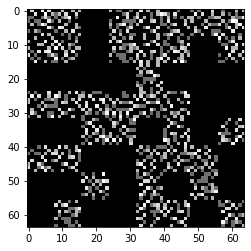

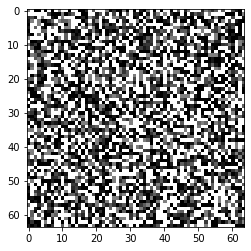

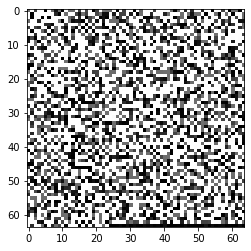

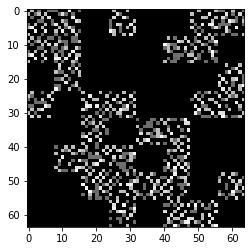

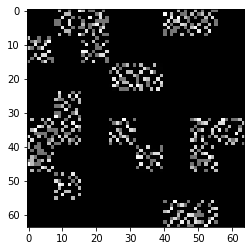

In [6]:
for i in range(0, 5):
    plt.imshow(tf.squeeze(train[i]), cmap = 'gray')
    plt.show()

In [ ]:
## create the training and testing data labels
## run if not using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [13]:
## create the training and testing data labels
## run this cell if using augmented data with rotated data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [7]:
## create the training and testing data labels
## run this cell if using augmented data and not with rotated data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [8]:
## create the dataframe for labels, then OHE the column
ytrain = pd.DataFrame(training_labels, columns = ['category'])
ytest = pd.DataFrame(testing_labels, columns = ['category'])

ytrain = pd.get_dummies(ytrain['category'])
ytest = pd.get_dummies(ytest['category'])

ytrain, ytest

(       attack  normal
 0           1       0
 1           1       0
 2           1       0
 3           1       0
 4           1       0
 ...       ...     ...
 10501       0       1
 10502       0       1
 10503       0       1
 10504       0       1
 10505       0       1
 
 [10506 rows x 2 columns],       attack  normal
 0          1       0
 1          1       0
 2          1       0
 3          1       0
 4          1       0
 ...      ...     ...
 1879       0       1
 1880       0       1
 1881       0       1
 1882       0       1
 1883       0       1
 
 [1884 rows x 2 columns])

In [9]:
## shuffle the data to prevent pattern recognition
train, ytrain = sklearn.utils.shuffle(train, ytrain, random_state = 0)
test, ytest = sklearn.utils.shuffle(test, ytest, random_state = 0)

In [22]:
KERNEL_SIZE = [4,4]
IMAGE_SIZE = [64,64,1]

cnn = Sequential()

## convolution 1
cnn.add(Convolution2D(2**2, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 2
cnn.add(Convolution2D(2**3, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 3
cnn.add(Convolution2D(2**4, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 4
cnn.add(Convolution2D(2**5, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 5
# cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.5))

# ## convolution 6
# cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
# cnn.add(Dense(256, activation='relu'))
cnn.add(Dense(128, activation='relu'))
# cnn.add(Dense(64, activation='relu'))
# cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation = 'sigmoid'))

# callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
            metrics = ['accuracy'])


cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 4)         68        
_________________________________________________________________
average_pooling2d_4 (Average (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 8)         520       
_________________________________________________________________
average_pooling2d_5 (Average (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 16)        2064      
_________________________________________________________________
average_pooling2d_6 (Average (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 32)         

In [23]:
start = time.time()
model_history = cnn.fit(train, ytrain, batch_size = 512, epochs = 300)
end = time.time()

# os.system(f'say "training finished in {round(end - start, 2)} seconds"')
print(f'Training finished in {round(end - start, 2)}')

Epoch 1/300
21/21 [==============================] - 1s 27ms/step - loss: 1.5201 - accuracy: 0.5291
Epoch 2/300
21/21 [==============================] - 0s 18ms/step - loss: 0.6777 - accuracy: 0.6359
Epoch 3/300
21/21 [==============================] - 0s 18ms/step - loss: 0.6502 - accuracy: 0.6356
Epoch 4/300
21/21 [==============================] - 0s 18ms/step - loss: 0.6261 - accuracy: 0.6584
Epoch 5/300
21/21 [==============================] - 0s 18ms/step - loss: 0.6214 - accuracy: 0.6605
Epoch 6/300
21/21 [==============================] - 0s 18ms/step - loss: 0.6191 - accuracy: 0.6570
Epoch 7/300
21/21 [==============================] - 0s 18ms/step - loss: 0.6090 - accuracy: 0.6683
Epoch 8/300
21/21 [==============================] - 0s 18ms/step - loss: 0.6108 - accuracy: 0.6574
Epoch 9/300
21/21 [==============================] - 0s 18ms/step - loss: 0.6032 - accuracy: 0.6721
Epoch 10/300
21/21 [==============================] - 0s 18ms/step - loss: 0.6071 - accuracy: 0.6690

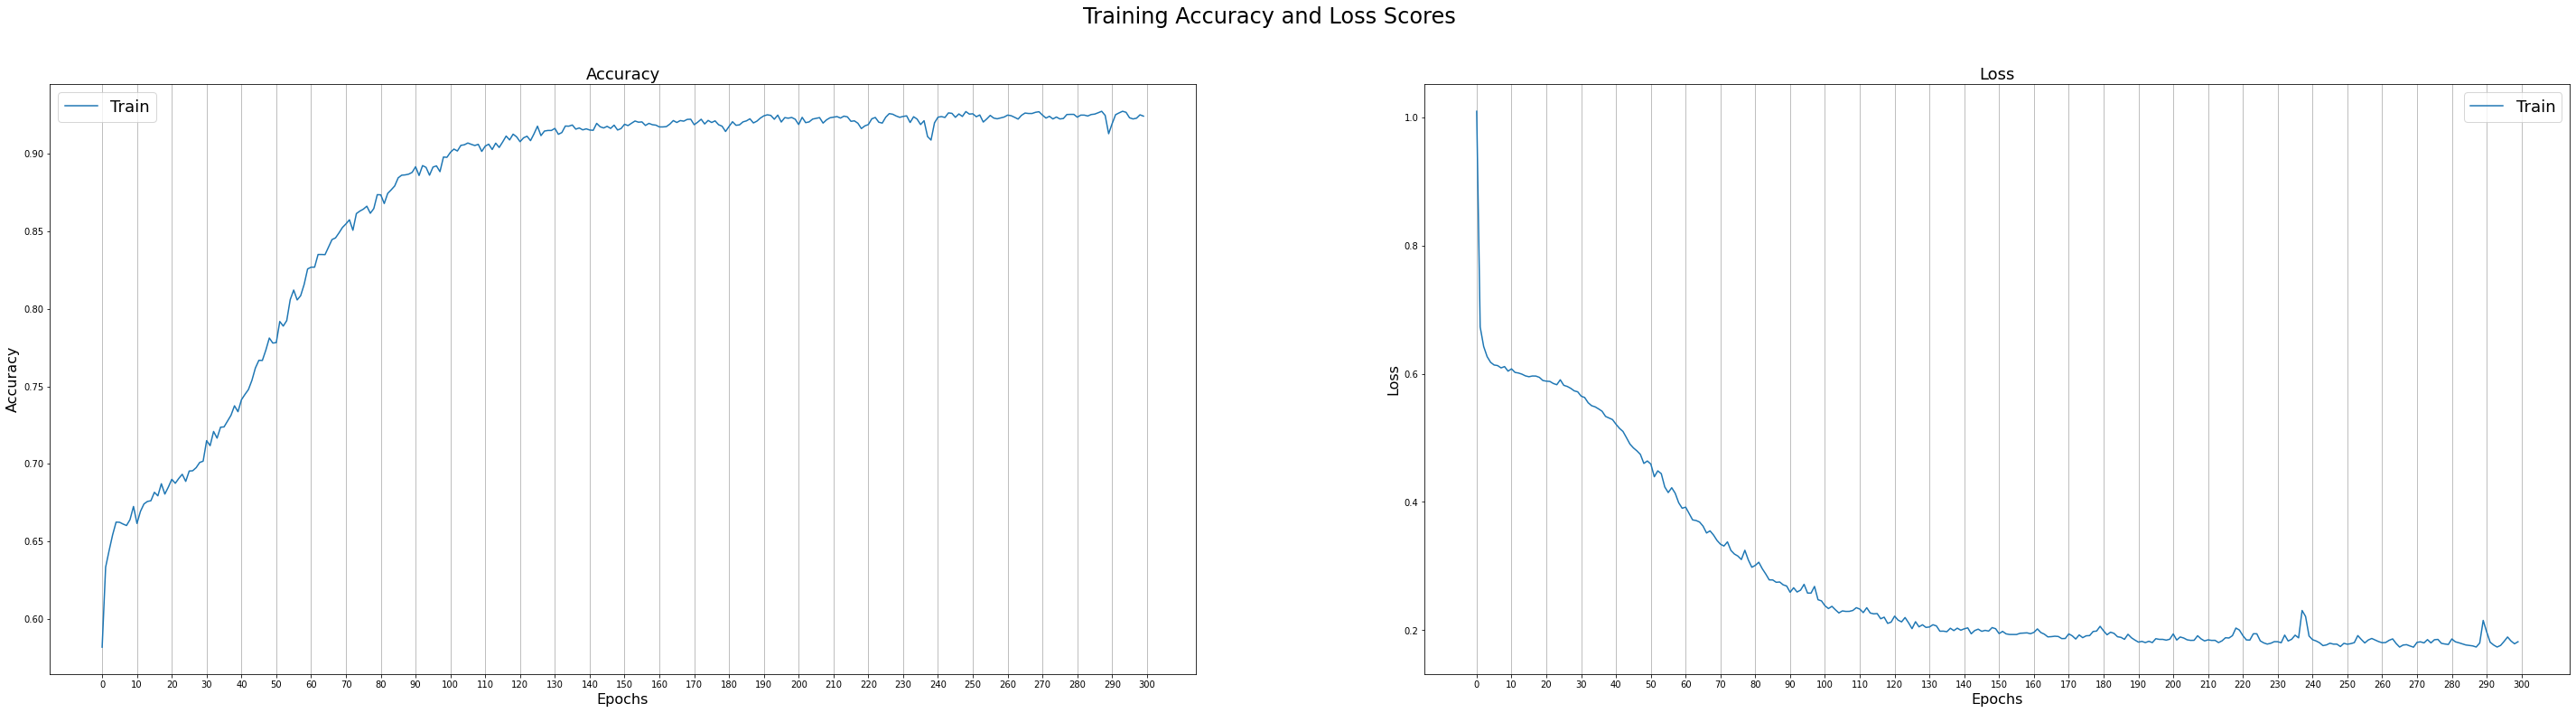

In [24]:
# print(model_history.history.keys())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50,12))
fig.suptitle('Training Accuracy and Loss Scores', fontsize = 24)

axes[0].plot(model_history.history['accuracy'])
axes[0].set_title('Accuracy', fontsize = 18)
axes[0].set_ylabel('Accuracy', fontsize = 16)
axes[0].set_xlabel('Epochs', fontsize = 16)
axes[0].set_xticks(np.arange(0, 310, step = 10))
axes[0].grid(axis = 'x')
axes[0].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

axes[1].plot(model_history.history['loss'])
axes[1].set_title('Loss', fontsize = 18)
axes[1].set_ylabel('Loss', fontsize = 16)
axes[1].set_xlabel('Epochs', fontsize = 16)
axes[1].set_xticks(np.arange(0, 310, step = 10))
axes[1].grid(axis = 'x')
axes[1].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

In [25]:
loss, acc = cnn.evaluate(test, ytest, batch_size = 512, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 5.4308	Accuracy = 55.67999999999999%


In [26]:
preds = cnn.predict(test)
y_preds = np.argmax(preds, axis = 1)

preds[:20]

array([[0.24071, 0.76665],
       [0.90091, 0.1002 ],
       [0.96399, 0.03584],
       [1.     , 0.     ],
       [0.00025, 0.99944],
       [0.2149 , 0.68334],
       [0.04104, 0.95681],
       [1.     , 0.     ],
       [0.02111, 0.97605],
       [0.23344, 0.76689],
       [1.     , 0.     ],
       [0.99973, 0.00038],
       [0.     , 1.     ],
       [0.04055, 0.95342],
       [0.00014, 0.99982],
       [0.99998, 0.00002],
       [0.23475, 0.7748 ],
       [0.7834 , 0.22186],
       [0.23344, 0.76689],
       [1.     , 0.     ]], dtype=float32)

In [39]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Convolution2D(16, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Convolution2D(32, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Convolution2D(64, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    ## convolution 5
    cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    ## convolution 6
    cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
    # cnn.add(Dense(256, activation='relu'))
    cnn.add(Dense(128, activation='relu'))
    # cnn.add(Dense(64, activation='relu'))
    # cnn.add(Dense(32, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(2, activation = 'sigmoid'))

    # callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

    cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
                metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 512, epochs = 300)

In [40]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, random_state = None)
score = cross_val_score(classifier, test, ytest, cv = kf)
print(f'Model Cross Validation: \n{round(score.mean(), 3)*100}%')
print(f'Model Cross Validation: \n{score}')

Epoch 1/300
3/3 [==============================] - 1s 228ms/step - loss: 0.7566 - accuracy: 0.5104
Epoch 2/300
3/3 [==============================] - 0s 60ms/step - loss: 0.6853 - accuracy: 0.5635
Epoch 3/300
3/3 [==============================] - 0s 59ms/step - loss: 0.6685 - accuracy: 0.6316
Epoch 4/300
3/3 [==============================] - 0s 61ms/step - loss: 0.6524 - accuracy: 0.6967
Epoch 5/300
3/3 [==============================] - 0s 61ms/step - loss: 0.6612 - accuracy: 0.7076
Epoch 6/300
3/3 [==============================] - 0s 62ms/step - loss: 0.6562 - accuracy: 0.7047
Epoch 7/300
3/3 [==============================] - 0s 60ms/step - loss: 0.6547 - accuracy: 0.6943
Epoch 8/300
3/3 [==============================] - 0s 61ms/step - loss: 0.6415 - accuracy: 0.6994
Epoch 9/300
3/3 [==============================] - 0s 62ms/step - loss: 0.6333 - accuracy: 0.7028
Epoch 10/300
3/3 [==============================] - 0s 62ms/step - loss: 0.6284 - accuracy: 0.7014
Epoch 11/300
3/3 [